# ML for Finance in Python

Explore the data with some EDA.

First, let's explore the data. Any time we begin a machine learning (ML) project, we need to first do some exploratory data analysis (EDA) to familiarize ourselves with the data. This includes things like:


*   raw data plots
*   histograms
*   and more...


I typically begin with raw data plots and histograms. This allows us to understand our data's distributions. If it's a normal distribution, we can use things like parametric statistics.

There are two stocks loaded into pandas DataFrames: lng_df and spy_df (LNG and SPY). Take a look at them with .head(). We'll use the closing prices and eventually volume as inputs to ML algorithms.

Note: We'll call plt.clf() each time we want to make a new plot, or f = plt.figure().

**Preparation: install yahoo stock api (Learn from Google)**

In [1]:
!pip install fix_yahoo_finance --upgrade --no-cache-dir

  Found existing installation: fix-yahoo-finance 0.0.22
    Uninstalling fix-yahoo-finance-0.0.22:
      Successfully uninstalled fix-yahoo-finance-0.0.22
  Running setup.py install for fix-yahoo-finance ... done


Upgrade Seaborn

In [2]:
!pip install seaborn --upgrade

Requirement already up-to-date: seaborn in /usr/local/lib/python2.7/dist-packages (0.9.0)


Import packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
yf.pdr_override()

From Yahoo get Apple Stock Data

In [4]:
AAPL  = pdr.get_data_yahoo(tickers =["AAPL"],
    start = "2017-04-01",
    end="2019-03-31",
    as_panel = False,
    )[['Adj Close','Volume']]

[*********************100%***********************]  1 of 1 downloaded


In [5]:
AAPL.head()

,Adj Close,Volume
Date,,
2017-04-03,139.34,19985700
2017-04-04,140.38,19891400
2017-04-05,139.65,27717900
2017-04-06,139.30,21149000
2017-04-07,138.99,16672200


**Step 1 : EDA**

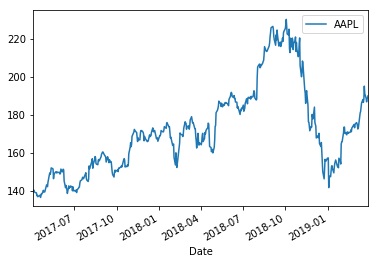

In [6]:
AAPL['Adj Close'].plot(label='AAPL', legend=True)


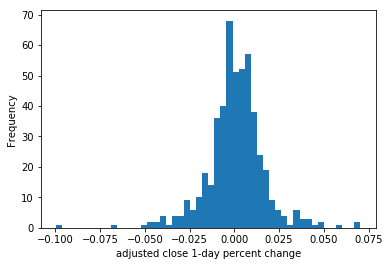

In [7]:
AAPL['Adj Close'].pct_change().plot.hist(bins=50)
plt.xlabel('adjusted close 1-day percent change')
plt.show()

**Step 2: Correlation**

Correlations are nice to check out before building machine learning models, because we can see which features correlate to the target most strongly. Pearson's correlation coefficient is often used, which only detects linear relationships. It's commonly assumed our data is normally distributed, which we can "eyeball" from histograms. Highly correlated variables have a Pearson correlation coefficient near 1 (positively correlated) or -1 (negatively correlated). A value near 0 means the two variables are not linearly correlated.

If we use the same time periods for previous price changes and future price changes, we can see if the stock price is mean-reverting (bounces around) or trend-following (goes up if it has been going up recently).

In [8]:
# Create 5-day % changes of Adj Close for the current day, and 5 days in the future
AAPL['5d_future_close'] = AAPL['Adj Close'].shift(-5)
AAPL['5d_close_future_pct'] = AAPL['5d_future_close'].pct_change(5)
AAPL['5d_close_pct'] = AAPL['Adj Close'].pct_change(5)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

In [9]:
# Calculate the correlation matrix between the 5d close pecentage changes (current and future)
corr = AAPL[['5d_close_pct', '5d_close_future_pct']].corr()
print(corr)

                     5d_close_pct  5d_close_future_pct
5d_close_pct             1.000000             0.044246
5d_close_future_pct      0.044246             1.000000


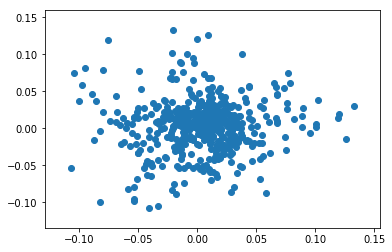

In [10]:
# Scatter the current 5-day percent change vs the future 5-day percent change
plt.scatter(AAPL['5d_close_pct'], AAPL['5d_close_future_pct'])
plt.show()

**Step 3: Create moving average and RSI features**

We want to add historical data to our machine learning models to make better predictions, but adding lots of historical time steps is tricky. Instead, we can condense information from previous points into a single timestep with indicators.

A moving average is one of the simplest indicators - it's the average of previous data points. This is the function **talib.SMA()** from the TAlib library.

Another common technical indicator is the relative strength index (RSI). This is defined by:

RSI=100−100/(1+RS)

RS=average gain over n periodsaverage loss over n periods.

The n periods is set in talib.RSI() as the timeperiod argument.


A common period for RSI is 14, so we'll use that as one setting in our calculations.

Import talib (Search from google ,can't just use** "import talib"** to install), the result is too long ( Q)

In [1]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib
import talib

The result of import talib is too long, So I delete the output

**Create moving average and RSI features use talib**

In [12]:
feature_names = ['5d_close_pct']  # a list of the feature names for later

# Create moving averages and rsi for timeperiods of 14, 30, 50, and 200
for n in [14,30,50,200]:

    # Create the moving average indicator and divide by Adj_Close
    AAPL['ma' + str(n)] = talib.SMA(AAPL['Adj Close'].values,
                              timeperiod=n) / AAPL['Adj Close']
    # Create the RSI indicator
    AAPL['rsi' + str(n)] = talib.RSI(AAPL['Adj Close'].values, timeperiod=n)
    
    # Add rsi and moving average to the feature name list
    feature_names = feature_names + ['ma' + str(n), 'rsi' + str(n)]

print(feature_names)

['5d_close_pct', 'ma14', 'rsi14', 'ma30', 'rsi30', 'ma50', 'rsi50', 'ma200', 'rsi200']


**Step 4: Create features and targets**


We almost have features and targets that are machine-learning ready -- we have features from current price changes (5d_close_pct) and indicators (moving averages and RSI), and we created targets of future price changes (5d_close_future_pct). Now we need to break these up into separate numpy arrays so we can feed them into machine learning algorithms.
.

In [13]:
AAPL.info()
# Drop all na values
AAPL = AAPL.dropna()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 501 entries, 2017-04-03 to 2019-03-29
Data columns (total 13 columns):
Adj Close              501 non-null float64
Volume                 501 non-null int64
5d_future_close        496 non-null float64
5d_close_future_pct    496 non-null float64
5d_close_pct           496 non-null float64
ma14                   488 non-null float64
rsi14                  487 non-null float64
ma30                   472 non-null float64
rsi30                  471 non-null float64
ma50                   452 non-null float64
rsi50                  451 non-null float64
ma200                  302 non-null float64
rsi200                 301 non-null float64
dtypes: float64(12), int64(1)
memory usage: 54.8 KB


In [14]:
# Create features and targets
# use feature_names for features; '5d_close_future_pct' for targets
features = AAPL[feature_names]
targets = AAPL['5d_close_future_pct']

# Create DataFrame from target column and feature columns
feature_and_target_cols = ['5d_close_future_pct'] + feature_names
feat_targ_df = AAPL[feature_and_target_cols]

# Calculate correlation matrix
corr = feat_targ_df.corr()
print(corr)

                     5d_close_future_pct  5d_close_pct      ma14     rsi14  \
5d_close_future_pct             1.000000      0.061184 -0.058513  0.076412   
5d_close_pct                    0.061184      1.000000 -0.860257  0.680071   
ma14                           -0.058513     -0.860257  1.000000 -0.856625   
rsi14                           0.076412      0.680071 -0.856625  1.000000   
ma30                           -0.120765     -0.677691  0.884796 -0.927052   
rsi30                           0.030112      0.522398 -0.706086  0.920185   
ma50                           -0.108988     -0.548118  0.749356 -0.881476   
rsi50                          -0.016072      0.411473 -0.579820  0.802826   
ma200                           0.114385     -0.216708  0.331897 -0.523175   
rsi200                         -0.092683      0.223514 -0.347018  0.546043   

                         ma30     rsi30      ma50     rsi50     ma200  \
5d_close_future_pct -0.120765  0.030112 -0.108988 -0.016072  0.11438

**Step 5: Check the correlations**

Before we fit our first machine learning model, let's look at the correlations between features and targets. Ideally we want large (near 1 or -1) correlations between features and targets. Examining correlations can help us tweak features to maximize correlation (for example, altering the timeperiod argument in the talib functions). It can also help us remove features that aren't correlated to the target.

To easily plot a correlation matrix, we can use seaborn's heatmap() function. This takes a correlation matrix as the first argument, and has many other options. Check out the annot option -- this will help us turn on annotations.

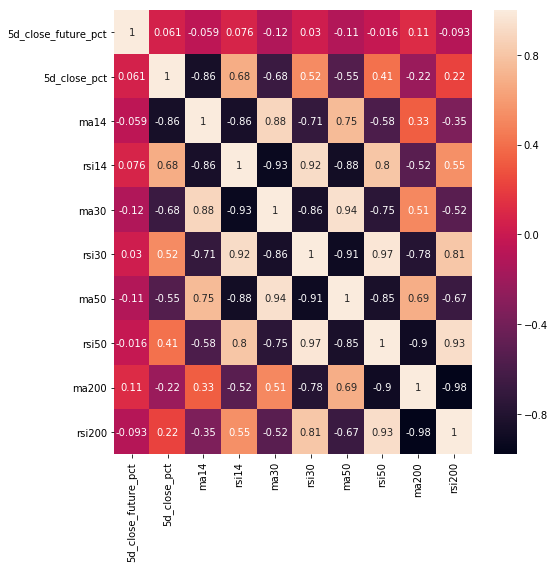

<Figure size 432x288 with 0 Axes>

In [15]:
# Plot heatmap of correlation matrix
# annot shows the number is the square
plt.figure(figsize = (8,8))
sns.heatmap(corr, annot=True)

# if put plt.figure(figsize = [15,15]) after the heatmap, it doesn't work!

plt.yticks(rotation=0); plt.xticks(rotation=90)  # fix ticklabel directions
plt.tight_layout()  # fits plot area to the plot, "tightly"
plt.show()  # show the plot
plt.clf()  # clear the plot area

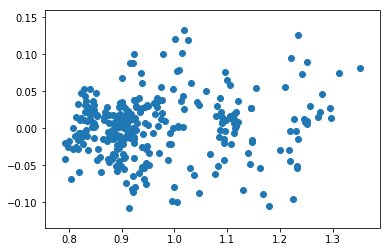

In [16]:

# Create a scatter plot of the most highly correlated variable with the target
plt.scatter(AAPL['ma200'],AAPL['5d_close_future_pct'])
plt.show()


# **Linear Modeling with financial Data**

**Step 6： Create train and test features**

Before we fit our linear model, we want to add a constant to our features, so we have an intercept for our linear model.

We also want to create train and test features. This is so we can fit our model to the train dataset, and evaluate performance on the test dataset. We always want to check performance on data the model has not seen to make sure we're not overfitting, which is memorizing patterns in the training data too exactly.

**With a time series like this, we typically want to use the oldest data as our training set, and the newest data as our test set.** 

This is so we can evaluate the performance of the model on the most recent data, which will more realistically simulate predictions on data we haven't seen yet.

Import the statsmodels.api library

In [ ]:
# Import the statsmodels.api library with the alias sm
import statsmodels.api as sm

In [18]:
# Add a constant to the features
linear_features = sm.add_constant(features)

# Create a size for the training set that is 85% of the total number of samples
train_size = int(0.85 * targets.shape[0])
train_features = linear_features[:train_size]
train_targets = targets[:train_size]
test_features = linear_features[train_size:]
test_targets = targets[train_size:]
print(linear_features.shape, train_features.shape, test_features.shape)

((296, 10), (251, 10), (45, 10))


/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


**Step 7: Fit a linear model**

We'll now fit a linear model, because they are simple and easy to understand. Once we've fit our model, we can see which predictor variables appear to be meaningfully linearly correlated with the target, as well as their magnitude of effect on the target. Our judgment of whether or not predictors are significant is based on the p-values of coefficients. This is using a t-test to statistically test if the coefficient significantly differs from 0. The p-value is the percent chance that the coefficient for a feature does not differ from zero. Typically, we take a p-value of less than 0.05 to mean the coefficient is significantly different from 0.

In [19]:
# Create the linear model and complete the least squares fit
model = sm.OLS(train_targets, train_features)
results = model.fit()  # fit the model
print(results.summary)

<bound method OLSResults.summary of <statsmodels.regression.linear_model.OLSResults object at 0x7ffa5c050410>>


In [20]:
# examine pvalues
# Features with p <= 0.05 are typically considered significantly different from 0
print(results.pvalues)

# Make predictions from our model for train and test sets
train_predictions = results.predict(train_features)
test_predictions = results.predict(test_features)

const           0.566530
5d_close_pct    0.119402
ma14            0.009094
rsi14           0.274764
ma30            0.221717
rsi30           0.393358
ma50            0.000346
rsi50           0.498691
ma200           0.011946
rsi200          0.817437
dtype: float64


 *Q: first time here, I din't drop NA, so it can't show the result*

**Step 8: Evaluate our results**

Once we have our linear fit and predictions, we want to see how good the predictions are so we can decide if our model is any good or not. Ideally, we want to back-test any type of trading strategy. However, this is a complex and typically time-consuming experience.

A quicker way to understand the performance of our model is looking at regression evaluation metrics like R2, and plotting the predictions versus the actual values of the targets. Perfect predictions would form a straight, diagonal line in such a plot, making it easy for us to eyeball how our predictions are doing in different regions of price changes. We can use matplotlib's .scatter() function to create scatter plots of the predictions and actual values.


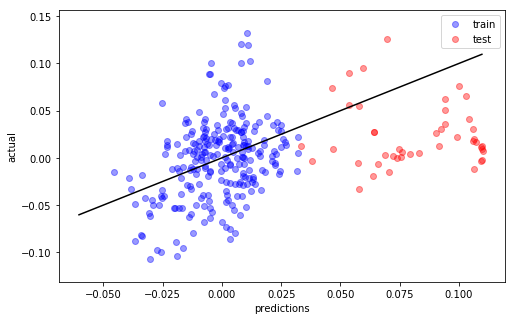

In [21]:
# Scatter the predictions vs the targets with 80% transparency
plt.figure(figsize = (8,5))
plt.scatter(train_predictions, train_targets, alpha=0.4, color='b', label='train')
plt.scatter(test_predictions, test_targets, alpha = 0.4, color='r', label='test')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k')

# Set the axis labels and show the plot
plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend()  # show the legend
plt.show()

# Machine learning tree methods

**Feature engineering from volume**

We're going to use non-linear models to make more accurate predictions. With linear models, features must be linearly correlated to the target. Other machine learning models can combine features in non-linear ways. For example, what if the price goes up when the moving average of price is going up, and the moving average of volume is going down? The only way to capture those interactions is to either multiply the features, or to use a machine learning algorithm that can handle non-linearity (e.g. random forests).

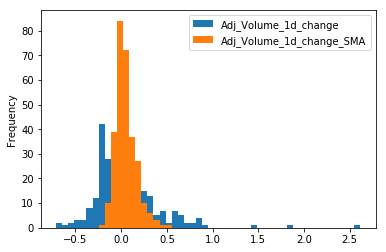

In [22]:
# Create 2 new volume features, 1-day % change and 5-day SMA of the % change
new_features = ['Adj_Volume_1d_change', 'Adj_Volume_1d_change_SMA']
feature_names.extend(new_features)
AAPL['Adj_Volume_1d_change'] = AAPL['Volume'].pct_change()
AAPL['Adj_Volume_1d_change_SMA'] = talib.SMA(AAPL['Adj_Volume_1d_change'].values,timeperiod=5)

# Plot histogram of volume % change data
AAPL[new_features].plot(kind='hist', sharex=False, bins=50)
plt.show()

**Create day-of-week features**

We can engineer datetime features to add even more information for our non-linear models. Most financial data has datetimes, which have lots of information in them -- year, month, day, and sometimes hour, minute, and second. But we can also get the day of the week, and things like the quarter of the year, or the elapsed time since some event (e.g. earnings reports).

We are only going to get the day of the week here, since our dataset doesn't go back very far in time. The dayofweek property from the pandas datetime index will help us get the day of the week. Then we will dummy dayofweek with pandas' get_dummies(). This creates columns for each day of the week with binary values (0 or 1). We drop the first column because it can be inferred from the others.

In [23]:
# Use pandas' get_dummies function to get dummies for day of the week
days_of_week = pd.get_dummies(AAPL.index.dayofweek,
                              prefix='weekday',
                              drop_first=True)

# Set the index as the original dataframe index for merging
days_of_week.index = AAPL.index

# Join the dataframe with the days of week dataframe
AAPL = pd.concat([AAPL, days_of_week], axis=1)

# Add days of week to feature names
feature_names.extend(['weekday_' + str(i) for i in range(1, 5)])
AAPL.dropna(inplace=True)  # drop missing values in-place
print(AAPL.head())

            Adj Close    Volume  5d_future_close  5d_close_future_pct  \
Date                                                                    
2018-01-25     167.86  41529000           164.59            -0.019481   
2018-01-26     168.25  39143000           157.45            -0.064190   
2018-01-29     164.77  50640400           153.52            -0.068277   
2018-01-30     163.80  46048200           159.93            -0.023626   
2018-01-31     164.25  32478900           156.51            -0.047123   

            5d_close_pct      ma14      rsi14      ma30      rsi30      ma50  \
Date                                                                           
2018-01-25     -0.045436  1.028046  40.643541  1.018295  49.660714  1.011657   
2018-01-26     -0.038956  1.024207  41.959045  1.015897  50.176284  1.009026   
2018-01-29     -0.051083  1.043121  34.591919  1.036497  45.842320  1.029935   
2018-01-30     -0.056886  1.046149  32.860039  1.041587  44.728320  1.035781   
2018-01-

**Examine correlations of the new features**

Now that we have our volume and datetime features, we want to check the correlations between our new features (stored in the new_features list) and the target (5d_close_future_pct) to see how strongly they are related. Recall pandas has the built-in .corr() method for DataFrames, and seaborn has a nice heatmap() function to show the correlation

In [ ]:
# Add the weekday labels to the new_features list
new_features.extend(['weekday_'+ str(i) for i in range(1, 5)])

.extend: This can only run once**, or else it literate times by times

In [25]:
new_features

['Adj_Volume_1d_change',
 'Adj_Volume_1d_change_SMA',
 'weekday_1',
 'weekday_2',
 'weekday_3',
 'weekday_4']

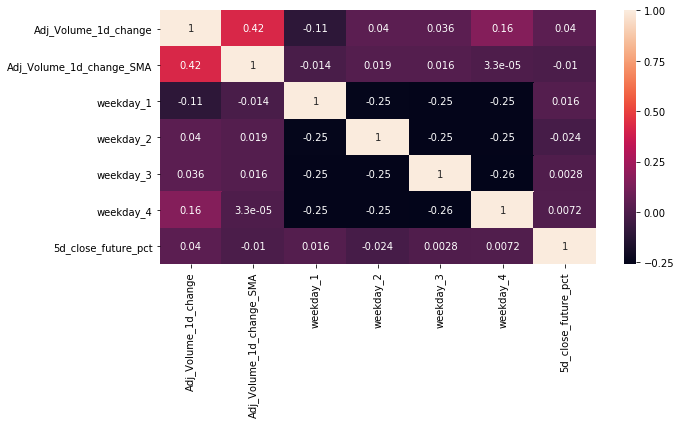

In [26]:

# Plot the correlations between the new features and the targets
plt.figure(figsize = (10,6))

sns.heatmap(AAPL[new_features + ['5d_close_future_pct']].corr(), annot=True)
plt.yticks(rotation=0)  # ensure y-axis ticklabels are horizontal
plt.xticks(rotation=90)  # ensure x-axis ticklabels are vertical
plt.tight_layout()
plt.show()

# Machine Learning: Decision tree

**Fit a decision tree**

Random forests are a go-to model for predictions; they work well out of the box. But we'll first learn the building block of random forests -- decision trees.

Decision trees split the data into groups based on the features. Decision trees start with a root node, and split the data down until we reach leaf nodes.



We can use sklearn to fit a decision tree with DecisionTreeRegressor and .fit(features, targets).

Without limiting the tree's depth (or height), it will keep splitting the data until each leaf has 1 sample in it, which is the epitome of overfitting. We'll learn more about overfitting in the coming chapters.

In [27]:
from sklearn.tree import DecisionTreeRegressor

# Create a decision tree regression model with default arguments
decision_tree = DecisionTreeRegressor()

# Fit the model to the training features and targets
decision_tree.fit(train_features, train_targets)

# Check the score on train and test
print(decision_tree.score(train_features, train_targets))
print(decision_tree.score(test_features, test_targets))

0.9999975743770261
-8.895143403052085


**Try different max depths **

We always want to optimize our machine learning models to make the best predictions possible. We can do this by tuning hyperparameters, which are settings for our models. We will see in more detail how these are useful in future chapters, but for now think of them as knobs we can turn to tune our predictions to be as good as possible.

For regular decision trees, probably the most important hyperparameter is ***max_depth***. This limits the number of splits in a decision tree. Let's find the best value of max_depth based on the ***R2*** score of our model on the test set, which we can obtain using the **score()** method of our decision tree models. 

In [28]:
# Loop through a few different max depths and check the performance
for d in [3,5,10]:
    # Create the tree and fit it
    decision_tree = DecisionTreeRegressor(max_depth= d)
    decision_tree.fit(train_features, train_targets)

    # Print out the scores on train and test
    print('max_depth=', str(d))
    print(decision_tree.score(train_features, train_targets))
    print(decision_tree.score(test_features, test_targets), '\n')

('max_depth=', '3')
0.42492112856449854
(-8.029561548246129, '\n')
('max_depth=', '5')
0.5655335041124006
(-8.617301826617856, '\n')
('max_depth=', '10')
0.9181103129768328
(-10.775671445031593, '\n')


**Check our results**

Once we have an optimized model, we want to check how it is performing in more detail. We already saw the R2 score, but it can be helpful to see the predictions plotted vs actual values. We can use the .predict() method of our decision tree model to get predictions on the train and test sets.

Ideally, we want to see diagonal lines from the lower left to the upper right. However, due to the simplicity of decisions trees, our model is not going to do well on the test set. But it will do well on the train set.

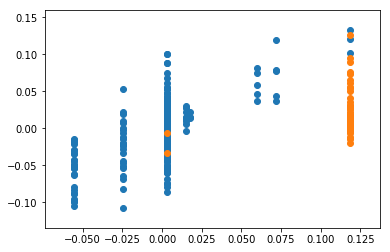

In [29]:
 # Use the best max_depth of 3 from last exercise to fit a decision tree
decision_tree = DecisionTreeRegressor(max_depth= 3)
decision_tree.fit(train_features, train_targets)

# Predict values for train and test
train_predictions = decision_tree.predict(train_features)
test_predictions = decision_tree.predict(test_features)

# Scatter the predictions vs actual values
plt.scatter(train_predictions, train_targets, label='train')
plt.scatter(test_predictions, test_targets, label= 'test')
plt.show()

**Random forests**

**Fit a random forest**
Data scientists often use random forest models. They perform well out of the box, and have lots of settings to optimize performance. Random forests can be used for classification or regression; we'll use it for regression to predict the future price change of LNG.

We'll create and fit the random forest model similarly to the decision trees using the .fit(features, targets) method. With sklearn's ***RandomForestRegressor***, there's a built-in ***.score() *method we can use to evaluate performance. This takes arguments (features, targets), and returns the R2 score (the coefficient of determination). 

In [30]:
from sklearn.ensemble import RandomForestRegressor

# Create the random forest model and fit to the training data
rfr = RandomForestRegressor(n_estimators=200)
rfr.fit(train_features, train_targets)

# Look at the R^2 scores on train and test
print(rfr.score(train_features, train_targets))
print(rfr.score(test_features, test_targets))

0.9190352644092232
-1.1500646805454644


**Tune random forest hyperparameters**

As with all models, we want to optimize performance by tuning hyperparameters. We have many hyperparameters for random forests, but the most important is often the number of features we sample at each split, or max_features in RandomForestRegressor from the sklearn library. For models like random forests that have randomness built-in, we also want to set the random_state. This is set for our results to be reproducible.

Usually, we can use sklearn's ***GridSearchCV() ***method to search hyperparameters, but with a financial time series, we don't want to do cross-validation due to data mixing. We want to fit our models on the oldest data and evaluate on the newest data. So we'll use sklearn's ***ParameterGrid*** to create combinations of hyperparameters to search.

In [31]:
from sklearn.model_selection import ParameterGrid

# Create a dictionary of hyperparameters to search
grid = {'n_estimators': [200], 'max_depth': [3], 'max_features': [4,8], 'random_state': [42]}
test_scores = []

# Loop through the parameter grid, set the hyperparameters, and save the scores
for g in ParameterGrid(grid):
    rfr.set_params(**g)  # ** is "unpacking" the dictionary
    rfr.fit(train_features, train_targets)
    test_scores.append(rfr.score(test_features, test_targets))

# Find best hyperparameters from the test score and print
best_idx = np.argmax(test_scores)
print(test_scores[best_idx], ParameterGrid(grid)[best_idx])

(-0.02447183671021058, {'n_estimators': 200, 'max_features': 4, 'random_state': 42, 'max_depth': 3})


**Evaluate performance**

Lastly, and as always, we want to evaluate performance of our best model to check how well or poorly we are doing. Ideally it's best to do back-testing, but that's an involved process we don't have room to cover in this course.

We've already seen the ***R2 ***scores, but let's take a look at the scatter plot of predictions vs actual results using ***matplotlib***. Perfect predictions would be a diagonal line from the lower left to the upper right.

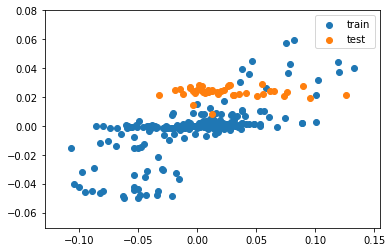

In [32]:
# Use the best hyperparameters from before to fit a random forest model
rfr = RandomForestRegressor(n_estimators=200, max_depth=3, max_features=4, random_state=42)
rfr.fit(train_features, train_targets)

# Make predictions with our model
train_predictions = rfr.predict(train_features)
test_predictions = rfr.predict(test_features)

# Create a scatter plot with train and test actual vs predictions
plt.scatter(train_targets, train_predictions, label='train')
plt.scatter(test_targets, test_predictions, label='test')
plt.legend()
plt.show()

**Feature importances and gradient boosting**

R**andom forest feature importances**

One useful aspect of tree-based methods is the ability to extract feature importances. This is a quantitative way to measure how much each feature contributes to our predictions. It can help us focus on our best features, possibly enhancing or tuning them, and can also help us get rid of useless features that may be cluttering up our model.

Tree models in sklearn have a*** .feature_importances_*** property that's accessible after fitting the model. This stores the feature importance scores. We need to get the indices of the sorted feature importances using ***np.argsort() ***in order to make a nice-looking bar plot of feature importances (sorted from greatest to least importance).

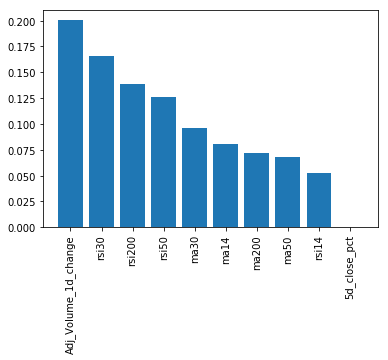

In [33]:
# Get feature importances from our random forest model
importances = rfr.feature_importances_

# Get the index of importances from greatest importance to least
sorted_index = np.argsort(importances)[::-1]
x = range(len(importances))

# Create tick labels 
labels = np.array(feature_names)[sorted_index]
plt.bar(x, importances[sorted_index], tick_label=labels)

# Rotate tick labels to vertical
plt.xticks(rotation=90)
plt.show()

**A gradient boosting model**

Now we'll fit a gradient boosting (GB) model. It's been said a linear model is like a Toyota Camry, and GB is like a Black Hawk helicopter. GB has potential to outperform random forests, but doesn't always do so. This is called the no free lunch theorem, meaning we should always try lots of different models for each problem.

GB is similar to random forest models, but the difference is that trees are built successively. With each iteration, the next tree fits the residual errors from the previous tree in order to improve the fit.

For now we won't search our hyperparameters -- they've been searched for you.

In [34]:
from sklearn.ensemble import GradientBoostingRegressor

# Create GB model -- hyperparameters have already been searched for you
gbr = GradientBoostingRegressor(max_features=4,
                                learning_rate=0.01,
                                n_estimators=200,
                                subsample=0.6,
                                random_state=42)
gbr.fit(train_features, train_targets)

print(gbr.score(train_features, train_targets))
print(gbr.score(test_features, test_targets))

0.4982341377762708
0.03194774398155009


**Gradient boosting feature importances**

As with random forests, we can extract feature importances from gradient boosting models to understand which features are the best predictors. Sometimes it's nice to try different tree-based models and look at the feature importances from all of them. This can help average out any peculiarities that may arise from one particular model.

The feature importances are stored as a ***numpy ***array in the ***.feature_importances_ ***property of the gradient boosting model. We'll need to get the sorted indices of the feature importances, using np.argsort(), in order to make a nice plot. We want the features from largest to smallest, so we will use Python's indexing to reverse the sorted importances like ***feat_importances[::-1].***

In [ ]:
# Extract feature importances from the fitted gradient boosting model
feature_importances = gbr.feature_importances_

# Get the indices of the largest to smallest feature importances
sorted_index = np.argsort(feature_importances)[::-1]
x = range(features.shape[1])



# Machine Learning: Scaling data and KNN Regression


**Standardizing data**

Some models, like K-nearest neighbors (KNN) & neural networks, work better with scaled data -- so we'll standardize our data.

We'll also remove unimportant variables (day of week), according to feature importances, by indexing the features DataFrames with ***.iloc[].*** KNN uses distances to find similar points for predictions, so big features outweigh small ones. Scaling data fixes that.

***sklearn's scale() ***will standardize data, which sets the mean to 0 and standard deviation to 1. Ideally we'd want to use ***StandardScaler*** with ***fit_transform() ***on the training data, and fit() on the test data, but we are limited to 15 lines of code here.

Once we've scaled the data, we'll check that it worked by plotting histograms of the data.

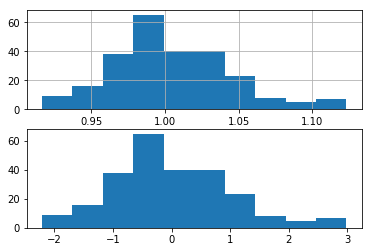

In [44]:
from sklearn.preprocessing import scale

# Remove unimportant features (weekdays)
train_features = train_features.iloc[:, :-4]
test_features = test_features.iloc[:, :-4]

# Standardize the train and test features
scaled_train_features = scale(train_features)
scaled_test_features = scale(test_features)

# Plot histograms of the 14-day SMA RSI before and after scaling
f, ax = plt.subplots(nrows=2, ncols=1)
train_features.iloc[:, 2].hist(ax=ax[0])
ax[1].hist(scaled_train_features[:, 2])
plt.show()

**Optimize n_neighbors**

Now that we have scaled data, we can try using a KNN model. To maximize performance, we should tune our model's hyperparameters. For the k-nearest neighbors algorithm, we only have one hyperparameter: **n**, the number of neighbors. We set this hyperparameter when we create the model with KNeighborsRegressor. The argument for the number of neighbors is n_neighbors.

We want to try a range of values that passes through the setting with the best performance. Usually we will start with 2 neighbors, and increase until our scoring metric starts to decrease. We'll use the R2 value from the ***.score()*** method on the test set (***scaled_test_features and test_targets***) to optimize n here. We'll use the test set scores to determine the best n.

In [45]:
from sklearn.neighbors import KNeighborsRegressor

for n in range(2,13):
    # Create and fit the KNN model
    knn = KNeighborsRegressor(n_neighbors= n)
    
    # Fit the model to the training data
    knn.fit(scaled_train_features, train_targets)
    
    # Print number of neighbors and the score to find the best value of n
    print("n_neighbors =", n)
    print('train, test scores')
    print(knn.score(scaled_train_features, train_targets))
    print(knn.score(scaled_test_features, test_targets))
    print()  # prints a blank line

('n_neighbors =', 2)
train, test scores
0.6562458230909551
-2.8430866322856945
()
('n_neighbors =', 3)
train, test scores
0.5411552925249177
-2.613591416708169
()
('n_neighbors =', 4)
train, test scores
0.4712476099298199
-2.1781777704828045
()
('n_neighbors =', 5)
train, test scores
0.4033242541011819
-2.004365211040514
()
('n_neighbors =', 6)
train, test scores
0.3403095448506611
-1.8265744193761786
()
('n_neighbors =', 7)
train, test scores
0.3240303412095106
-1.7974979828994684
()
('n_neighbors =', 8)
train, test scores
0.2771069214358133
-1.759064449056348
()
('n_neighbors =', 9)
train, test scores
0.23110792151015758
-1.7268712636926478
()
('n_neighbors =', 10)
train, test scores
0.213916765254472
-1.5179988882303292
()
('n_neighbors =', 11)
train, test scores
0.19310270383686423
-1.5146664987980976
()
('n_neighbors =', 12)
train, test scores
0.17890886943365625
-1.5165857752269796
()


**Evaluate KNN performance**

We just saw a few things with our KNN scores. For one, the training scores started high and decreased with increasing n, which is typical. The test set performance reached a peak at 5 though, and we will use that as our setting in the final KNN model.

As we have done a few times now, we will check our performance visually. This helps us see how well the model is predicting on different regions of actual values. We will get predictions from our knn model using the .predict() method on our scaled features. Then we'll use matplotlib's plt.scatter() to create a scatter plot of actual versus predicted values.

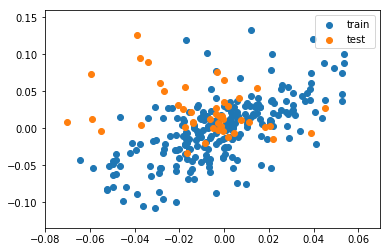

In [46]:
# Create the model with the best-performing n_neighbors of 5
knn = KNeighborsRegressor(n_neighbors= 5)

# Fit the model
knn.fit(scaled_train_features, train_targets)

# Get predictions for train and test sets
train_predictions = knn.predict(scaled_train_features)
test_predictions = knn.predict(scaled_test_features)

# Plot the actual vs predicted values
plt.scatter(train_predictions, train_targets, label='train')
plt.scatter(test_predictions, test_targets, label= 'test')
plt.legend()
plt.show()

# Machine Learning: Neural Networks


**Build and fit a simple neural net**


The next model we will learn how to use is a neural network. Neural nets can capture complex interactions between variables, but are difficult to set up and understand. Recently, they have been beating human experts in many fields, including image recognition and gaming (check out AlphaGo) -- so they have great potential to perform well.

To build our nets we'll use the ***keras library.*** This is a high-level API that allows us to quickly make neural nets, yet still exercise a lot of control over the design. The first thing we'll do is create almost the simplest net possible -- a 3-layer net that takes our inputs and predicts a single value. Much like the sklearn models, keras models have a .fit() method that takes arguments of (features, targets).

In [47]:
from keras.models import Sequential
from keras.layers import Dense

# Create the model
model_1 = Sequential()
model_1.add(Dense(100, input_dim=scaled_train_features.shape[1], activation='relu'))
model_1.add(Dense(20, activation='relu'))
model_1.add(Dense(1, activation='linear'))

# Fit the model
model_1.compile(optimizer='adam', loss='mse')
history = model_1.fit(scaled_train_features, train_targets, epochs=25)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/25
251/251 [==============================] - 1s 2ms/step - loss: 0.0038
Epoch 2/25
251/251 [==============================] - 0s 52us/step - loss: 0.0023
Epoch 3/25
251/251 [==============================] - 0s 60us/step - loss: 0.0019
Epoch 4/25
251/251 [==============================] - 0s 56us/step - loss: 0.0018
Epoch 5/25
251/251 [==============================] - 0s 50us/step - loss: 0.0015
Epoch 6/25
251/251 [==============================] - 0s 56us/step - loss: 0.0016
Epoch 7/25
251/251 [==============================] - 0s 60us/step - loss: 0.0015
Epoch 8/25
251/251 [==============================] - 0s 57us/step - loss: 0.0014
Epoch 9/25
251/251 [==============================] - 0s 55us/step - loss: 0.0014
Epoch 10/25
251/251 [==============================] - 0s 56us/step - loss: 0.0014
Epoch 11/25
251/251 [==============================] - 0s 58

**Plot losses**

Once we've fit a model, we usually check the training loss curve to make sure it's flattened out. The history returned from model.fit() is a dictionary that has an entry, 'loss', which is the training loss. We want to ensure this has more or less flattened out at the end of our training.

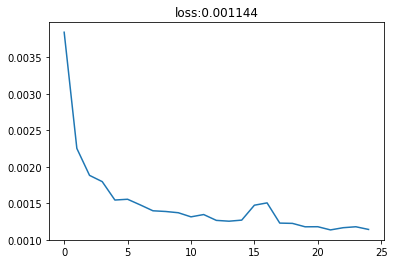

In [48]:
# Plot the losses from the fit
plt.plot(history.history['loss'])

# Use the last loss as the title
plt.title('loss:' + str(round(history.history['loss'][-1], 6)))
plt.show()

**Measure performance**

Now that we've fit our neural net, let's check performance to see how well our model is predicting new values. There's not a built-in .score() method like with sklearn models, so we'll use the r2_score() function from sklearn.metrics. This calculates the R2 score given arguments (y_true, y_predicted). We'll also plot our predictions versus actual values again. This will yield some interesting results soon (once we implement our own custom loss function).

0.37889331813718685
-2.252699740363762


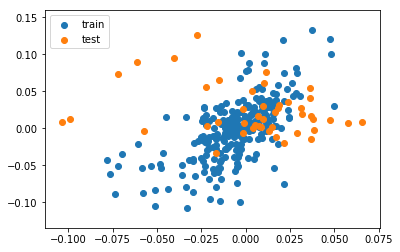

In [49]:
from sklearn.metrics import r2_score

# Calculate R^2 score
train_preds = model_1.predict(scaled_train_features)
test_preds = model_1.predict(scaled_test_features)
print(r2_score(train_targets, train_preds))
print(r2_score(test_targets, test_preds))

# Plot predictions vs actual
plt.scatter(train_preds, train_targets, label='train')
plt.scatter(test_preds, test_targets, label= 'test')
plt.legend()
plt.show()

**Custom loss functions**


Up to now, we've used the mean squared error as a loss function. This works fine, but with stock price prediction it can be useful to implement a custom loss function. A custom loss function can help improve our model's performance in specific ways we choose. For example, we're going to create a custom loss function with a large penalty for predicting price movements in the wrong direction. This will help our net learn to at least predict price movements in the correct direction.

To do this, we need to write a function that takes arguments of (y_true, y_predicted). We'll also use functionality from the backend keras (using tensorflow) to find cases where the true value and prediction don't match signs, then penalize those cases.

In [50]:
import keras.losses
import tensorflow as tf

# Create loss function
def sign_penalty(y_true, y_pred):
    penalty = 100.
    loss = tf.where(tf.less(y_true * y_pred, 0), \
                     penalty * tf.square(y_true - y_pred), \
                     tf.square(y_true - y_pred))

    return tf.reduce_mean(loss, axis=-1)

keras.losses.sign_penalty = sign_penalty  # enable use of loss with keras
print(keras.losses.sign_penalty)

<function sign_penalty at 0x7ffa433d9500>


**Fit neural net with custom loss function**

Now we'll use the custom loss function we just created. This will enable us to alter the model's behavior in useful ways particular to our problem -- it's going to try to force the model to learn how to at least predict price movement direction correctly. All we need to do now is set the ***loss*** argument in our*** .compile() ***function to our function name, ***sign_penalty***. We'll examine the training loss again to make sure it's flattened out.

Epoch 1/25
251/251 [==============================] - 0s 886us/step - loss: 0.6966
Epoch 2/25
251/251 [==============================] - 0s 50us/step - loss: 0.3947
Epoch 3/25
251/251 [==============================] - 0s 50us/step - loss: 0.3083
Epoch 4/25
251/251 [==============================] - 0s 50us/step - loss: 0.2114
Epoch 5/25
251/251 [==============================] - 0s 58us/step - loss: 0.1528
Epoch 6/25
251/251 [==============================] - 0s 55us/step - loss: 0.1150
Epoch 7/25
251/251 [==============================] - 0s 60us/step - loss: 0.0842
Epoch 8/25
251/251 [==============================] - 0s 69us/step - loss: 0.0732
Epoch 9/25
251/251 [==============================] - 0s 66us/step - loss: 0.0735
Epoch 10/25
251/251 [==============================] - 0s 55us/step - loss: 0.0671
Epoch 11/25
251/251 [==============================] - 0s 59us/step - loss: 0.0525
Epoch 12/25
251/251 [==============================] - 0s 70us/step - loss: 0.0748
Epoch 13/25


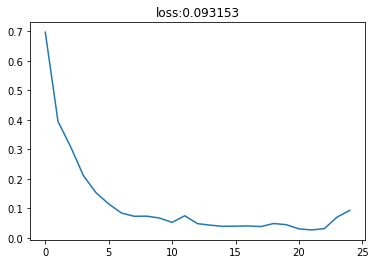

In [51]:
# Create the model
model_2 = Sequential()
model_2.add(Dense(100, input_dim= scaled_train_features.shape[1], activation='relu'))
model_2.add(Dense(20, activation='relu'))
model_2.add(Dense(1, activation='linear'))

# Fit the model with our custom 'sign_penalty' loss function
model_2.compile(optimizer='adam', loss=sign_penalty)
history = model_2.fit(scaled_train_features, train_targets, epochs=25)
plt.plot(history.history['loss'])
plt.title('loss:' + str(round(history.history['loss'][-1], 6)))
plt.show()

**Visualize the results**

We've fit our model with the custom loss function, and it's time to see how it is performing. We'll check the R2 values again with sklearn's r2_score() function, and we'll create a scatter plot of predictions versus actual values with plt.scatter(). This will yield some interesting results!

0.15821913625450035
-7.269011731115864


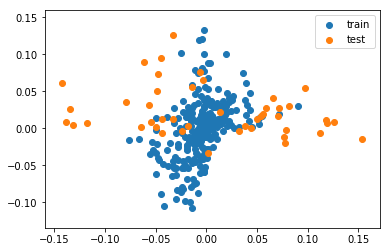

In [52]:
# Evaluate R^2 scores
train_preds = model_2.predict(scaled_train_features)
test_preds = model_2.predict(scaled_test_features)
print(r2_score(train_targets, train_preds))
print(r2_score(test_targets, test_preds))

# Scatter the predictions vs actual -- this one is interesting!
plt.scatter(train_preds, train_targets, label='train')
plt.scatter(test_preds, test_targets, label='test')  # plot test set
plt.legend(); plt.show()

# Overfitting and ensembling

**Combatting overfitting with dropout**

A common problem with neural networks is they tend to overfit to training data. What this means is the scoring metric, like R2 or accuracy, is high for the training set, but low for testing and validation sets, and the model is fitting to noise in the training data.

We can work towards preventing overfitting by using dropout. This randomly drops some neurons during the training phase, which helps prevent the net from fitting noise in the training data. ***keras*** has a ***Dropout l***ayer that we can use to accomplish this. We need to set the dropout rate, or fraction of connections dropped during training time. This is set as a decimal between 0 and 1 in the ***Dropout()*** layer.

We're going to go back to the mean squared error loss function for this model.

Epoch 1/25
251/251 [==============================] - 0s 1ms/step - loss: 0.0535
Epoch 2/25
251/251 [==============================] - 0s 64us/step - loss: 0.0291
Epoch 3/25
251/251 [==============================] - 0s 55us/step - loss: 0.0122
Epoch 4/25
251/251 [==============================] - 0s 59us/step - loss: 0.0076
Epoch 5/25
251/251 [==============================] - 0s 57us/step - loss: 0.0093
Epoch 6/25
251/251 [==============================] - 0s 58us/step - loss: 0.0061
Epoch 7/25
251/251 [==============================] - 0s 56us/step - loss: 0.0052
Epoch 8/25
251/251 [==============================] - 0s 57us/step - loss: 0.0052
Epoch 9/25
251/251 [==============================] - 0s 58us/step - loss: 0.0040
Epoch 10/25
251/251 [==============================] - 0s 58us/step - loss: 0.0049
Epoch 11/25
251/251 [==============================] - 0s 57us/step - loss: 0.0064
Epoch 12/25
251/251 [==============================] - 0s 60us/step - loss: 0.0047
Epoch 13/25
25

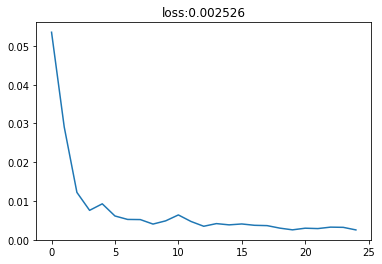

In [54]:
from keras.layers import Dropout

# Create model with dropout
model_3 = Sequential()
model_3.add(Dense(100, input_dim=scaled_train_features.shape[1], activation='relu'))
model_3.add(Dropout(0.2))
model_3.add(Dense(20, activation='relu'))
model_3.add(Dense(1, activation='linear'))

# Fit model with mean squared error loss function
model_3.compile(optimizer='adam', loss='mse')
history = model_3.fit(scaled_train_features, train_targets, epochs=25)
plt.plot(history.history['loss'])
plt.title('loss:' + str(round(history.history['loss'][-1], 6)))
plt.show();

**Ensembling models**

One approach to improve predictions from machine learning models is ensembling. A basic approach is to average the predictions from multiple models. A more complex approach is to feed predictions of models into another model, which makes final predictions. Both approaches usually improve our overall performance (as long as our individual models are good). If you remember, random forests are also using ensembling of many decision trees.

To ensemble our neural net predictions, we'll make predictions with the 3 models we just created -- the basic model, the model with the custom loss function, and the model with dropout. Then we'll combine the predictions with*** numpy's .hstack()*** function, and average them across rows with np.mean(predictions, axis=1)

In [55]:
# Make predictions from the 3 neural net models
train_pred1 = model_1.predict(scaled_train_features)
test_pred1 = model_1.predict(scaled_test_features)

train_pred2 = model_2.predict(scaled_train_features)
test_pred2 = model_2.predict(scaled_test_features)

train_pred3 = model_3.predict(scaled_train_features)
test_pred3 = model_3.predict(scaled_test_features)

# Horizontally stack predictions and take the average across rows
train_preds = np.mean(np.hstack((train_pred1, train_pred2, train_pred3)), axis=1)
test_preds = np.mean(np.hstack((test_pred1, test_pred2, test_pred3)), axis=1)
print(test_preds[-5:])

[-0.01392377 -0.01265657 -0.0092204  -0.00511049 -0.01214387]


**See how the ensemble performed**

Let's check performance of our ensembled model to see how it's doing. We should see roughly an average of the R2 scores, as well as a scatter plot that is a mix of our previous models' predictions. The bow-tie shape from the custom loss function model should still be a bit visible, but the edges near x=0 should be softer.

0.2882962418691972
-2.9534071305187957


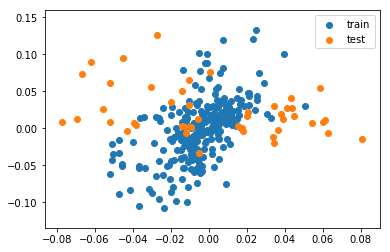

In [56]:
from sklearn.metrics import r2_score

# Evaluate the R^2 scores
print(r2_score(train_targets, train_preds))
print(r2_score(test_targets, test_preds))

# Scatter the predictions vs actual -- this one is interesting!
plt.scatter(train_preds, train_targets, label='train')
plt.scatter(test_preds, test_targets, label='test')
plt.legend(); plt.show()

# Modern portfolio theory (MPT); efficient frontiers

**Step1: Join stock DataFrames and calculate returns**

Our first step towards calculating modern portfolio theory (MPT) portfolios is to get daily and monthly returns. 

Eventually we're going to get the best portfolios of each month based on the Sharpe ratio. The easiest way to do this is to put all our stock prices into one DataFrame, then to resample them to the daily and monthly time frames. We need daily price changes to calculate volatility, which we will use as our measure of risk.

In [84]:
FB  = pdr.get_data_yahoo(tickers =["FB"],
    start = "2015-04-01",
    end="2019-03-31",
    as_panel = False,
    )[['Adj Close']]
FB.columns = ['FB']

[*********************100%***********************]  1 of 1 downloaded


In [85]:
BABA  = pdr.get_data_yahoo(tickers =["BABA"],
    start = "2015-04-01",
    end="2019-03-31",
    as_panel = False,
    )[['Adj Close']]
BABA.columns = ['BABA']

[*********************100%***********************]  1 of 1 downloaded


In [86]:
AMZN  = pdr.get_data_yahoo(tickers =["AMZN"],
    start = "2015-04-01",
    end="2019-03-31",
    as_panel = False,
    )[['Adj Close']]
AMZN.columns = ['AMZN']

[*********************100%***********************]  1 of 1 downloaded


In [87]:
# Join 3 stock dataframes together
full_df = pd.concat([FB, AMZN, BABA], axis=1).dropna()

# Resample the full dataframe to monthly timeframe
monthly_df = full_df.resample('BMS').first()

# Calculate daily returns of stocks
returns_daily = full_df.pct_change()

# Calculate monthly returns of the stocks
returns_monthly = monthly_df.pct_change().dropna()

print(returns_daily.head())
print(returns_monthly.tail())

                  FB      AMZN      BABA
Date                                    
2015-04-01       NaN       NaN       NaN
2015-04-02 -0.001347  0.005375 -0.000971
2015-04-06  0.010790  0.012868 -0.005591
2015-04-07 -0.001456 -0.006975  0.004767
2015-04-08 -0.000486  0.018135  0.038681
                  FB      AMZN      BABA
Date                                    
2018-11-01 -0.065809 -0.169046 -0.066358
2018-12-03 -0.070247  0.064142  0.082579
2019-01-01 -0.038344 -0.131593 -0.165140
2019-02-01  0.221330  0.056590  0.228749
2019-03-01 -0.020699  0.027979  0.094719


**Step2: Calculate covariances for volatility**

In MPT, we quantify risk via volatility. The math for calculating portfolio volatility is complex, and it requires daily returns covariances. 

We'll now **loop through each month **in the ***returns_monthly ***DataFrame, and calculate the covariance of the daily returns.

With pandas datetime indices, we can access the month and year with **df.index.month** and **df.index.year**. 

We'll use this to ***create a mask for returns_daily ***that gives us the **daily returns** for the current month and year in the loop. We then use the mask to subset the DataFrame like this: ***df[mask]. ***This gets entries in the ***returns_daily*** DataFrame which are in the current month and year in each cycle of the loop. Finally, we'll use **pandas' .cov() **method to get the **covariance** of daily returns.

In [88]:
# Daily covariance of stocks (for each monthly period)
covariances = {}
rtd_idx = returns_daily.index
for i in returns_monthly.index:
    # Mask daily returns for each month and year, and calculate covariance
    mask = (rtd_idx.month == i.month) & (rtd_idx.year == i.year)
    
    # Use the mask to get daily returns for the current month and year of monthy returns index
    covariances[i] = returns_daily[mask].cov()

print(covariances[i])

            FB      AMZN      BABA
FB    0.000270  0.000077  0.000090
AMZN  0.000077  0.000225  0.000179
BABA  0.000090  0.000179  0.000244


**Step3: Calculate portfolios**

We'll now generate portfolios to find **each month's best one. **numpy's ***random.random() ***generates random numbers from a uniform distribution, then we normalize them so they sum to 1 using the ***/= operator.*** We use these **weights** to calculate returns and volatility. **Returns are sums of weights times individual returns**. Volatility is more complex, and involves the covariances of the different stocks.

Finally we'll store the values in dictionaries for later use, with months' dates as keys.

In this case, **we will only generate 10 portfolios for each date so the code will run faster**, but in a real-world use-case you'd want to use more like 1000 to 5000 randomly-generated portfolios for a few stocks.

In [89]:
portfolio_returns, portfolio_volatility, portfolio_weights = {}, {}, {}

# Get portfolio performances at each month
for date in sorted(covariances.keys()):
    cov = covariances[date]
    for portfolio in range(10):
        weights = np.random.random(3)
        weights /= np.sum(weights) # /= divides weights by their sum to normalize
        returns = np.dot(weights, returns_monthly.loc[date])
        volatility = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
        portfolio_returns.setdefault(date, []).append(returns)
        portfolio_volatility.setdefault(date, []).append(volatility)
        portfolio_weights.setdefault(date, []).append(weights)
        
print(portfolio_weights[date][0])

[0.0611801  0.40778414 0.53103576]


**Step 4: Plot efficient frontier**


We can finally plot the results of our MPT portfolios, which shows the "efficient frontier". This is a plot of the volatility vs the returns. This can help us visualize our risk-return possibilities for portfolios. The upper left boundary of the points is the best we can do (highest return for a given risk), and that is the efficient frontier.

To create this plot, we will use the latest date in our covariances dictionary which we created a few exercises ago. This has dates as keys, so we'll get the sorted keys using sorted() and .keys(), then get the last entry with Python indexing ([-1]). Lastly we'll use matplotlib to scatter variance vs returns and see the efficient frontier for the latest date in the data.

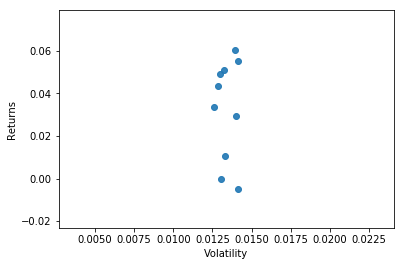

In [90]:
# Get latest date of available data
date = sorted(covariances.keys())[-1]  

# Plot efficient frontier
# warning: this can take at least 10s for the plot to execute...
plt.scatter(x=portfolio_volatility[date], y=portfolio_returns[date],  alpha=0.9)
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.show()